In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

from MatCSCM import MatCSCM, keyword_to_text
from CEB import *
from plotcurves import *

# CSCM Material Keyword Generator

This interactive tool generates CSCM material keywords for LS-DYNA based on specified concrete parameters.

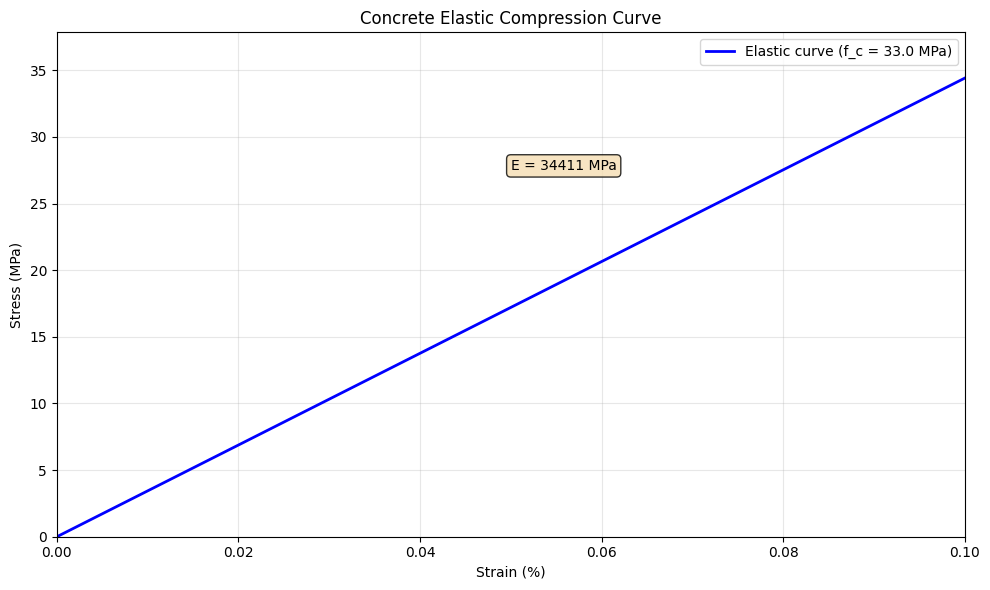

In [2]:
# Elastic compression curve visualization
def plot_elastic_compression_curve(f_c):
    """
    Plot elastic compression curve for concrete
    
    Parameters:
    f_c : float
        Characteristic compressive strength of concrete (MPa)
    """
    # Define strain range from 0 to 0.1% (0.001)
    strain_range = np.linspace(0, 0.001, 100)
    
    # Calculate elastic stress using CEB function
    from CEB import sigma_elastic
    stress_values = sigma_elastic(f_c, strain_range)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(strain_range * 100, stress_values, 'b-', linewidth=2, label=f'Elastic curve (f_c = {f_c} MPa)')
    plt.xlabel('Strain (%)')
    plt.ylabel('Stress (MPa)')
    plt.title('Concrete Elastic Compression Curve')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xlim(0, 0.1)
    plt.ylim(0, max(stress_values) * 1.1)
    
    # Add annotations
    ceb_data = CEB(f_c=f_c)
    E = ceb_data['E']
    plt.text(0.05, max(stress_values) * 0.8, f'E = {E:.0f} MPa', 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Initial plot with default f_c value
plot_elastic_compression_curve(33.0)

In [3]:
# Create interactive widgets for parameter input
f_c_widget = widgets.FloatText(
    value=33.0,
    description='f_c (MPa):',
    disabled=False,
    style={'description_width': 'initial'}
)

d_max_widget = widgets.FloatText(
    value=18.0,
    description='d_max (mm):',
    disabled=False,
    style={'description_width': 'initial'}
)

rho_widget = widgets.FloatText(
    value=2.4E-09,
    description='rho:',
    disabled=False,
    style={'description_width': 'initial'}
)

nplot_widget = widgets.Dropdown(
    options=[
        ('1: Maximum of brittle and ductile damage (default)', 1),
        ('2: Maximum of brittle and ductile damage, with recovery of brittle damage', 2),
        ('3: Brittle damage', 3),
        ('4: Ductile damage', 4),
        ('5: κ (intersection of cap with shear surface)', 5),
        ('6: X₀ (intersection of cap with pressure axis)', 6),
        ('7: εᵥᵖ (plastic volume strain)', 7)
    ],
    value=1,
    description='NPLOT:',
    disabled=False,
    style={'description_width': 'initial'}
)

iretrc_widget = widgets.Dropdown(
    options=[
        ('0: Cap does not retract (default)', 0),
        ('1: Cap retracts', 1)
    ],
    value=0,
    description='IRETRC:',
    disabled=False,
    style={'description_width': 'initial'}
)

output_widget = widgets.Output()
curve_output_widget = widgets.Output()

def update_output(*args):
    with output_widget:
        output_widget.clear_output()
        
        f_c = f_c_widget.value
        d_max = d_max_widget.value
        rho = rho_widget.value
        nplot = nplot_widget.value
        iretrc = iretrc_widget.value
        
        mat_cscm = MatCSCM(
            f_c=f_c,
            dmax=d_max,
            rho=rho,
            nplot=nplot,
            itretrc=iretrc,
            irate='on',
            erode='off',
            pred='off',
            recov='full'
        )
        
        keyword_data = mat_cscm.generate_keyword()
        result = keyword_to_text(keyword_data) + mat_cscm.get_ceb_output()
        print(result)

# Bind update function to widget changes
f_c_widget.observe(update_output, names='value')

def update_elastic_curve(*args):
    with curve_output_widget:
        curve_output_widget.clear_output()
        f_c = f_c_widget.value
        plot_elastic_compression_curve(f_c)

f_c_widget.observe(update_elastic_curve, names='value')
d_max_widget.observe(update_output, names='value')
rho_widget.observe(update_output, names='value')
nplot_widget.observe(update_output, names='value')
iretrc_widget.observe(update_output, names='value')

# Display widgets
display(widgets.VBox([
    widgets.HTML('<h3>Material Parameters</h3>'),
    f_c_widget,
    d_max_widget,
    rho_widget,
    nplot_widget,
    iretrc_widget,
    widgets.HTML('<h3>Elastic Compression Curve</h3>'),
    curve_output_widget,
    widgets.HTML('<h3>Result</h3>'),
    output_widget
]))

# Initialize output
update_output()
update_elastic_curve()